In [1]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/08_Resnet'
sys.path.append(my_path)
os.listdir(my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataTorchTransformLoad.py',
 'Test_Train.py',
 'VS_NET.py',
 'Plots.py',
 'GBN_NET.py',
 '__pycache__',
 'outputs',
 '06_Modular_Main.ipynb',
 '01_CIFAR+Baseline.ipynb',
 'Resnet.py']

In [2]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import sys
import random

# import for all the modular codes
import VS_NET
import Test_Train
import Plots
import dataTorchTransformLoad as dtl
import Resnet
#import GBN_NET



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# # Modelling options for the loop


# d1 = {'NO L1&L1': [0.,0.,'model'],
#       'L1 Only': [1e-04,0.,'model'], 
#       'L2 Only': [0.,1e-04,'model'],
#       'L1&L2':[1e-04,1e-04,'model'],
#       'GBN Only': [0,0,'model2'],
#       'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 20
input_ch=3

metric_values = {}
models={}

batch_size_GPU=64
batch_size_CPU=16




In [4]:
# Transforms

transforms_cifar_train = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomHorizontalFlip(),
                                      # transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.49139968, 0.48215841, 0.44653091], 
                                          [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  transforms.RandomErasing()
                                      # Note the difference between (0.1307) and (0.1307,)
                                      ])
transforms_cifar_test = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [5]:
# download data

train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms_cifar_train)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms_cifar_test) 

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [7]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


[['cat' 'car' 'truck' 'cat' 'cat' 'ship' 'bird' 'frog']
 ['plane' 'cat' 'horse' 'car' 'frog' 'bird' 'truck' 'deer']
 ['truck' 'horse' 'plane' 'dog' 'deer' 'car' 'deer' 'truck']
 ['horse' 'cat' 'car' 'car' 'deer' 'ship' 'plane' 'dog']
 ['dog' 'frog' 'horse' 'horse' 'bird' 'plane' 'frog' 'horse']
 ['bird' 'car' 'bird' 'deer' 'bird' 'dog' 'cat' 'deer']
 ['cat' 'dog' 'cat' 'ship' 'frog' 'truck' 'bird' 'ship']
 ['truck' 'dog' 'frog' 'ship' 'bird' 'dog' 'car' 'car']]


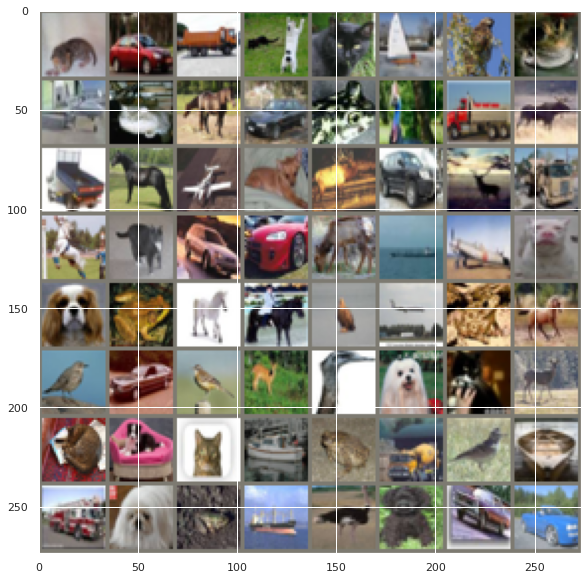

In [9]:
# functions to show an image
def imageshow(img):
    # img = img / 2 + 0.5      #unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

random.seed(1)
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
random.seed(1)
imageshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(64)))
print(np.array([classes[labels[j]] for j in range(64)]).reshape(8,8))

# Network -Base

In [16]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = VS_NET.Net(dropout_value,3).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             270
       BatchNorm2d-2           [-1, 10, 30, 30]              20
              ReLU-3           [-1, 10, 30, 30]               0
           Dropout-4           [-1, 10, 30, 30]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
              ReLU-7           [-1, 10, 28, 28]               0
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 16, 26, 26]           1,440
      BatchNorm2d-10           [-1, 16, 26, 26]              32
             ReLU-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
        MaxPool2d-13           [-1, 16, 13, 13]               0
           Conv2d-14           [-1, 10,

# Rune Base Model


In [18]:
from torch.optim.lr_scheduler import StepLR

model =  VS_NET.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

In [19]:
exp_name = 'base_model'

trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=1.3813786506652832 Batch_id=781 Accuracy=36.98: 100%|██████████| 782/782 [00:29<00:00, 26.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4861, Accuracy: 4559/10000 (45.59%)

EPOCH: 1
learning rate  [0.01]


Loss=1.154647707939148 Batch_id=781 Accuracy=49.89: 100%|██████████| 782/782 [00:29<00:00, 26.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2853, Accuracy: 5325/10000 (53.25%)

EPOCH: 2
learning rate  [0.01]


Loss=2.201122522354126 Batch_id=781 Accuracy=55.00: 100%|██████████| 782/782 [00:29<00:00, 26.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2313, Accuracy: 5577/10000 (55.77%)

EPOCH: 3
learning rate  [0.01]


Loss=1.5797497034072876 Batch_id=781 Accuracy=56.99: 100%|██████████| 782/782 [00:29<00:00, 26.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2016, Accuracy: 5661/10000 (56.61%)

EPOCH: 4
learning rate  [0.01]


Loss=1.1877354383468628 Batch_id=781 Accuracy=58.33: 100%|██████████| 782/782 [00:30<00:00, 26.03it/s]



Test set: Average loss: 1.1518, Accuracy: 5859/10000 (58.59%)



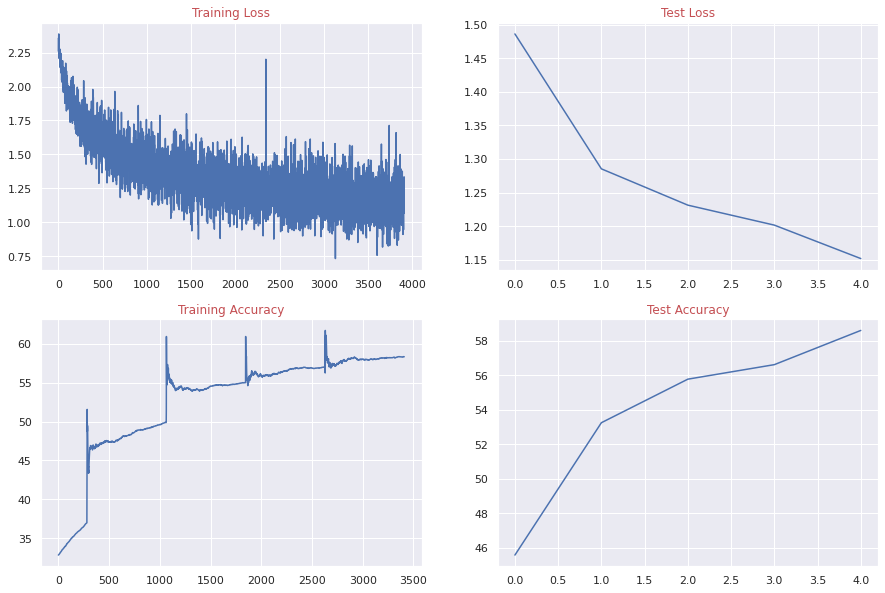

In [20]:
Plots.plot_metrics(train_metric, test_metric)

#RESNET

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/08_Resnet/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [11]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

In [12]:
exp_name = 'base_model'

trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,
                             EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/08_Resnet/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=0.9816659688949585 Batch_id=781 Accuracy=51.73: 100%|██████████| 782/782 [00:54<00:00, 14.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1077, Accuracy: 6103/10000 (61.03%)

EPOCH: 1
learning rate  [0.01]


Loss=0.4719224274158478 Batch_id=781 Accuracy=72.78: 100%|██████████| 782/782 [00:54<00:00, 14.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6963, Accuracy: 7649/10000 (76.49%)

EPOCH: 2
learning rate  [0.01]


Loss=0.7786142826080322 Batch_id=781 Accuracy=79.74: 100%|██████████| 782/782 [00:54<00:00, 14.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5723, Accuracy: 8047/10000 (80.47%)

EPOCH: 3
learning rate  [0.01]


Loss=0.6166762113571167 Batch_id=781 Accuracy=83.66: 100%|██████████| 782/782 [00:54<00:00, 14.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Accuracy: 8194/10000 (81.94%)

EPOCH: 4
learning rate  [0.01]


Loss=0.38622403144836426 Batch_id=781 Accuracy=86.30: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5929, Accuracy: 8110/10000 (81.10%)

EPOCH: 5
learning rate  [0.01]


Loss=0.7036480903625488 Batch_id=781 Accuracy=88.56: 100%|██████████| 782/782 [00:54<00:00, 14.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4991, Accuracy: 8353/10000 (83.53%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.20309270918369293 Batch_id=781 Accuracy=93.62: 100%|██████████| 782/782 [00:54<00:00, 14.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3855, Accuracy: 8728/10000 (87.28%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.0931103378534317 Batch_id=781 Accuracy=94.84: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3812, Accuracy: 8746/10000 (87.46%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.18089981377124786 Batch_id=781 Accuracy=95.48: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3789, Accuracy: 8779/10000 (87.79%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.1709222048521042 Batch_id=781 Accuracy=96.18: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3847, Accuracy: 8768/10000 (87.68%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.08793243020772934 Batch_id=781 Accuracy=96.36: 100%|██████████| 782/782 [00:54<00:00, 14.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3835, Accuracy: 8774/10000 (87.74%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.06507258862257004 Batch_id=781 Accuracy=96.74: 100%|██████████| 782/782 [00:54<00:00, 14.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3894, Accuracy: 8786/10000 (87.86%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.016044463962316513 Batch_id=781 Accuracy=97.09: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3877, Accuracy: 8801/10000 (88.01%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.11478589475154877 Batch_id=781 Accuracy=97.29: 100%|██████████| 782/782 [00:54<00:00, 14.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3881, Accuracy: 8788/10000 (87.88%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.2814648449420929 Batch_id=781 Accuracy=97.21: 100%|██████████| 782/782 [00:54<00:00, 14.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3877, Accuracy: 8790/10000 (87.90%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.06516958028078079 Batch_id=781 Accuracy=97.29: 100%|██████████| 782/782 [00:54<00:00, 14.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3870, Accuracy: 8790/10000 (87.90%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.18302413821220398 Batch_id=781 Accuracy=97.41: 100%|██████████| 782/782 [00:53<00:00, 14.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3874, Accuracy: 8785/10000 (87.85%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.04121130704879761 Batch_id=781 Accuracy=97.26: 100%|██████████| 782/782 [00:53<00:00, 14.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3919, Accuracy: 8784/10000 (87.84%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.024627290666103363 Batch_id=781 Accuracy=97.32: 100%|██████████| 782/782 [00:54<00:00, 14.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3893, Accuracy: 8783/10000 (87.83%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.6423566341400146 Batch_id=781 Accuracy=97.44: 100%|██████████| 782/782 [00:54<00:00, 14.45it/s]



Test set: Average loss: 0.3881, Accuracy: 8798/10000 (87.98%)



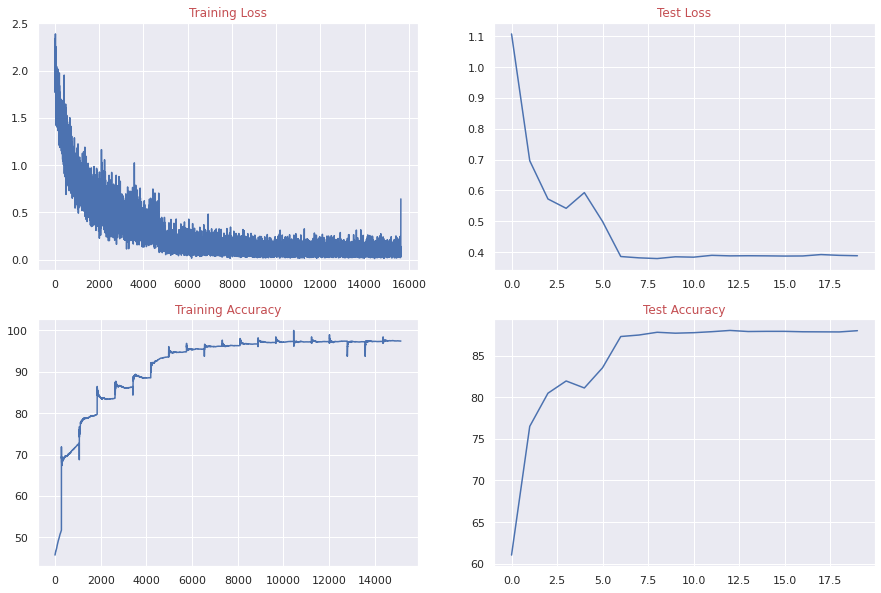

In [13]:
Plots.plot_metrics(train_metric, test_metric)

In [ ]:
Plots.multi_plots_loss(metric_values)
Plots.multi_plots_acc(metric_values)

# Plot misclassified

In [ ]:
# plot_misclassified(model2,test_loader,device)

Plots.plot_misclassified(model2,test_loader,device)